### introduction 

In this project, we develop a comprehensive news processing pipeline that integrates web scraping, text summarization, categorization, and data storage. The code begins by importing essential libraries and defining classes for web scraping articles from various sources, including the New York Times API. We then implement a text summarization pipeline using advanced transformer models, which distills large articles into concise summaries. Additionally, we leverage the Replicate API to categorize the extracted content into predefined categories like technology, science, and health. Finally, the extracted and categorized data is stored in ChromaDB, enabling efficient querying and retrieval for future analysis. This holistic approach streamlines the process of gathering, summarizing, and organizing news articles, providing valuable insights quickly and effectively.

In [1]:
REPLICATE_API = 'r8_aou3FQhGSrJapfkH20J60hjTzsaIdQB4MRPky'
NYT_API = '0a0rlbxwURqkelF0gzGvgcc2LCdoSTp0'

### 1. Import necessary libraries

In [3]:
# 1. Import necessary libraries
import requests
from bs4 import BeautifulSoup
import os
import replicate
from transformers import pipeline
import chromadb
from chromadb.utils import embedding_functions
import xml.etree.ElementTree as ET
import pandas as pd

### 2. Web Scraping Classes


In [4]:
import requests
from bs4 import BeautifulSoup


class WebScraper:
    def __init__(self, url, headers=None):
        self.url = url

    @staticmethod
    def extract_paragraphs(self, html_content):
        if html_content:
            soup = BeautifulSoup(html_content, 'html.parser')
            paragraph = [p.text for p in soup.find_all('p')]
            return paragraph
        else:
            return []

    def fetch_page(self):
        response = requests.get(self.url)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Failed to fetch the page. Status code: {response.status_code}")
            return None

    def fetch_and_extract_p(self):
        response = requests.get(self.url)
        if response.status_code == 200:
            paragraph = self.extract_paragraphs(self, response.text)
            return " ".join(paragraph)
        else:
            print(f"Failed to fetch the page. Status code: {response.status_code}")
            return None

In [5]:
class NYTimesAPI:
    """
    High Level API to access New York Times news from the official NYTimes API.
    The API only supports extraction of the most prominent lead-paragraph.
    """
    def __init__(self):
        self.api_key = '0a0rlbxwURqkelF0gzGvgcc2LCdoSTp0'  # Set the API KEY
        self.base_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json'  # default base url

    def get_response(self, news_topic) -> list:
        """
        Fetches the news.
        :param news_topic: supports news_topic and urls
        :return: abstract + description + lead_paragraph
        """
        url = f'{self.base_url}?q={news_topic}&api-key={self.api_key}'
        response = req.get(url).json()
        if 'response' in response and 'docs' in response['response']:
            docs = response['response']['docs']
            print(docs)
            abstract = docs[0].get('abstract', '')
            snippet = docs[0].get('snippet', '')
            lead_paragraph = docs[0].get('lead_paragraph', '')
            result = abstract + ' ' + snippet + ' ' + lead_paragraph
            return result
        return []


### 3. Text Summarization

In [6]:
from transformers import pipeline


class TextSummarizationPipeline:
    def __init__(self, model_name="dhivyeshrk/bart-large-cnn-samsum"):
        self.pipe = pipeline("text2text-generation", model=model_name)

    def generate_summary(self, input_text):
        words = input_text.split(" ")
        if len(words) > 500:
            input_text = " ".join(words[:500])
        return self.pipe(input_text)


# Example Usage
if __name__ == "__main__":
    text_generator = TextSummarizationPipeline()
    input_text = "Arena BioWorks is promising big paydays to nearly 100 researchers from Harvard, M.I.T. and other prestigious institutions. Arena BioWorks is promising big paydays to nearly 100 researchers from Harvard, M.I.T. and other prestigious institutions. In an unmarked laboratory stationed between the campuses of Harvard and the Massachusetts Institute of Technology, a splinter group of scientists is hunting for the next billion-dollar drug."

    output_summary = text_generator.generate_summary(input_text)
    print(output_summary)

c:\Users\milan\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'generated_text': 'Arena BioWorks is promising big paydays to nearly 100 researchers from Harvard, M.I.T. and other prestigious institutions. In an unmarked laboratory, a splinter group of scientists is hunting for the next billion-dollar drug.   \xa0'}]


### 4. Categorization with Replicate API

In [7]:
import os
import replicate

class ReplicateAPI:
    """
    High Level and Scalable API for accessing any model hosted on Replicate AI.
    """
    def __init__(self, model_name, api_token='r8_bqnIBRtzwoY0DzXXbKD7Wh1LmaiP8tA3Ujh8U'):
        os.environ['REPLICATE_API_TOKEN'] = api_token
        self.model_name = model_name
        self.input_params = {
            "top_k": 0,  # Keep top_k to zero for broad token selection
            "top_p": 0.95,  # Probability threshold for token sampling
            "prompt": "",
            "max_new_tokens": 10,  # Allow more tokens for a complete response
            "temperature": 0.2,  # Low temperature to reduce randomness
            "length_penalty": 1,  # Avoid long responses, favor shorter outputs
            "presence_penalty": 0,  # Neutral value, no bias towards repetition
            "stop_sequences": "<|end_of_text|>,<|eot_id|>",  # Stop sequences to prevent unnecessary generation
            "prompt_template": '''
                <|begin_of_text|><|start_header_id|>system<|end_header_id|>
                You are a helpful assistant. 
                <|eot_id|><|start_header_id|>user<|end_header_id>

                {prompt}
                \nPlease respond in the format: [number, '.', 'category_name'].
                \nWhich of the following classes does the above statement fall into: 
                1. Technology
                2. Sports
                3. Science
                4. Health
                5. General
                \nEnsure your response contains both the number and the full category name, like this: [3, '.', 'Science'].
                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
            '''
        }

    def run_model(self, prompt) -> str:
        """
        Run the model with the provided prompt and return the categorized output.
        """
        # Set the prompt
        self.input_params['prompt'] = prompt

        try:
            # Call the LLaMA 3 model using the replicate API
            out = replicate.run(self.model_name, input=self.input_params)
            
            # Debug: Print the full output to understand the response structure
            #print("Full response:", out)

            # Assuming the output is a list, and we want to join the elements into a string
            if isinstance(out, list) and len(out) > 0:
                result = ''.join(out).strip()  # Join and clean the output by stripping unnecessary spaces
                return result
            else:
                print("Unexpected output format:", out)
                return ""
        except Exception as e:
            print(f"Error occurred: {e}")
            return ""

if __name__ == '__main__':
    # Switch the model to LLaMA 3, e.g., 'meta/meta-llama-3-8b-instruct'
    api = ReplicateAPI(model_name='meta/meta-llama-3-8b-instruct')

    # Example prompt to classify
    prompt = "How automation is affecting the job market"
    output = api.run_model(prompt)
    
    # Expected output: [3, '.', 'Science'] or similar
    print(output)

[1, '.', 'Technology']


### 5. LLM Evaluation

In [14]:
def categorize(prompt: str, model: str) -> str:
    """
    Categorizes the prompt using specified LLM from ReplicateAI API
    :param model: Name of LLM
    :param prompt: user_prompt
    :return: categorized category
    """
    api = ReplicateAPI(model_name=model)
    output = api.run_model(prompt)
    output = [element.lower().strip() for element in output]
    categories = ['Technology', 'Science', 'Health', 'Sports']
    relevant_category = next((element for element in output if element in categories), None)
    if relevant_category:
        return relevant_category
    else:
        return ""

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
# Ensure the categories match in terms of formatting
ground_truth = ['Technology', 'Science', 'Health', 'Sports']  

# Predictions should also be in lowercase
predictions = []
test_prompts = [
    "A breakthrough in AI technology",
    "The latest scientific discoveries on Mars",
    "New advances in healthcare",
    "Results from last night's football game"
]
# Make predictions
for prompt in test_prompts:
    predicted_category = categorize(prompt, model='meta/meta-llama-3-8b-instruct')
    predictions.append(predicted_category.lower())  # Ensure lowercase

# Calculate accuracy
correct_predictions = sum(p == gt for p, gt in zip(predictions, ground_truth))
accuracy = correct_predictions / len(ground_truth)

# Calculate precision, recall, and F1 score
precision = precision_score(ground_truth, predictions, average='weighted', zero_division=0)  # Handle zero division
recall = recall_score(ground_truth, predictions, average='weighted', zero_division=0)
f1 = f1_score(ground_truth, predictions, average='weighted', zero_division=0)

# Confusion Matrix
conf_matrix = confusion_matrix(ground_truth, predictions)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 50.00%
Precision: 0.38
Recall: 0.50
F1 Score: 0.42
Confusion Matrix:
[[0 0 0 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [0 0 0 0 1]]


### 6. XML Parsing

In [9]:
import xml.etree.ElementTree as ET


class XMLParser:
    def __init__(self, file_path):
        self.file_path = file_path
        self.root = None
        self.data = []

    def parse_xml(self):
        with open(self.file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
        self.root = ET.fromstring(xml_content)

    def extract_information(self):
        if self.root is None:
            raise ValueError("XML not parsed. Call parse_xml() first.")
        # Iterate through each 'item' element and extract information
        for item in self.root.findall('.//item'):
            title = item.find('title').text
            link = item.find('link').text
            description = item.find('description').text

            # Extracting domains from categories
            domains = [category.text for category in item.findall('.//category[@domain]')]

            item_info = {
                'title':title,
                'link':link,
                'description':description,
                'domains':domains
            }
            self.data.append(item_info)

        return self.data


### 7. EDA

In [12]:
from dataframe import df

                                               title  \
0  Looming Starvation in Gaza Shows Resurgence of...   
1  Women With Depression During or After Pregnanc...   
2  U.S. Diet Panel Adds Another Researcher With A...   
3  What Happens When There Is No Food: Experts Sa...   
4  ‘Gas-Station Heroin’ Sold as Dietary Supplemen...   

                                                link  \
0  https://www.nytimes.com/2024/01/11/health/gaza...   
1  https://www.nytimes.com/2024/01/10/health/peri...   
2  https://www.nytimes.com/2024/01/10/health/alco...   
3  https://www.nytimes.com/2024/01/11/health/gaza...   
4  https://www.nytimes.com/2024/01/10/health/gas-...   

                                         description  \
0  A U.N.-affiliated panel said the territory cou...   
1  Two studies concluded that depression that beg...   
2  After dropping two Harvard experts who had rec...   
3  Nutrition experts say the progression from hun...   
4  Tianeptine, found at convenience stores, at

In [16]:
df.head(5)

,title,link,description,domains
0,Looming Starvation in Gaza Shows Resurgence of...,https://www.nytimes.com/2024/01/11/health/gaza...,A U.N.-affiliated panel said the territory cou...,"[Israel-Gaza War (2023- ), Famine, World Food ..."
1,Women With Depression During or After Pregnanc...,https://www.nytimes.com/2024/01/10/health/peri...,Two studies concluded that depression that beg...,"[your-feed-health, your-feed-healthcare, Suici..."
2,U.S. Diet Panel Adds Another Researcher With A...,https://www.nytimes.com/2024/01/10/health/alco...,After dropping two Harvard experts who had rec...,"[your-feed-science, Conflicts of Interest, Alc..."
3,What Happens When There Is No Food: Experts Sa...,https://www.nytimes.com/2024/01/11/health/gaza...,Nutrition experts say the progression from hun...,"[Gaza Strip, Famine, Malnutrition, Children an..."
4,‘Gas-Station Heroin’ Sold as Dietary Supplemen...,https://www.nytimes.com/2024/01/10/health/gas-...,"Tianeptine, found at convenience stores, at sm...","[your-feed-science, audio-neutral-informative,..."


In [18]:
print(df.isnull().sum())


title          0
link           0
description    0
domains        0
dtype: int64


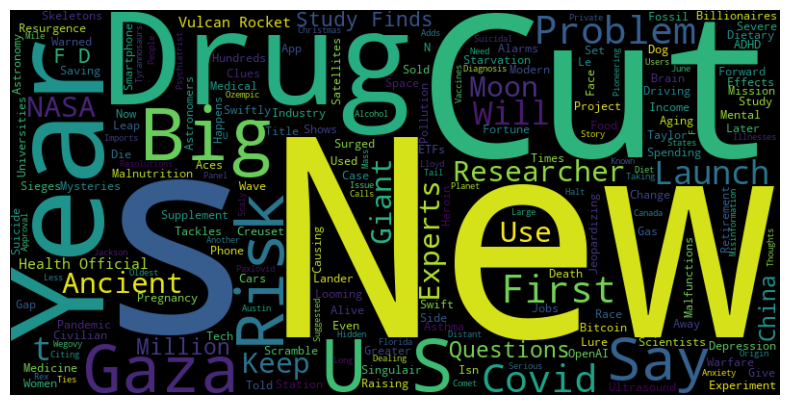

In [19]:
#Most Common Words in Titles
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_titles = ' '.join(df['title'])
wordcloud = WordCloud(width=800, height=400).generate(all_titles)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [20]:
# Unique Values in Domains
unique_domains = df['domains'].explode().unique()
print(unique_domains)

['Israel-Gaza War (2023- )' 'Famine' 'World Food Program'
 'Integrated Food Security Phase Classification' 'Hamas' 'Gaza Strip'
 'Israel' 'War Crimes, Genocide and Crimes Against Humanity'
 'Humanitarian Aid' 'your-feed-health' 'your-feed-healthcare'
 'Suicides and Suicide Attempts' 'Women and Girls'
 'Pregnancy and Childbirth' 'Research' 'Depression (Mental)'
 'JAMA Network Open' 'BMJ (Journal)' 'Sweden' 'your-feed-science'
 'Conflicts of Interest' 'Alcoholic Beverages' 'Diet and Nutrition'
 'Medicine and Health' 'Heart' 'Harvard University'
 'National Academies of Sciences, Engineering and Medicine' 'Malnutrition'
 'Children and Childhood' 'Embargoes and Sanctions'
 'audio-neutral-informative' 'Tianeptine'
 'Dietary Supplements and Herbal Remedies' 'Poisoning and Poisons'
 'Opioids and Opiates' 'Food and Drug Administration' 'United States'
 'Regulation and Deregulation of Industry' 'Addiction (Psychology)'
 'Drug Abuse and Traffic' 'Brain' 'Ultrasonic Imaging and Sonograms'
 "Alzhei

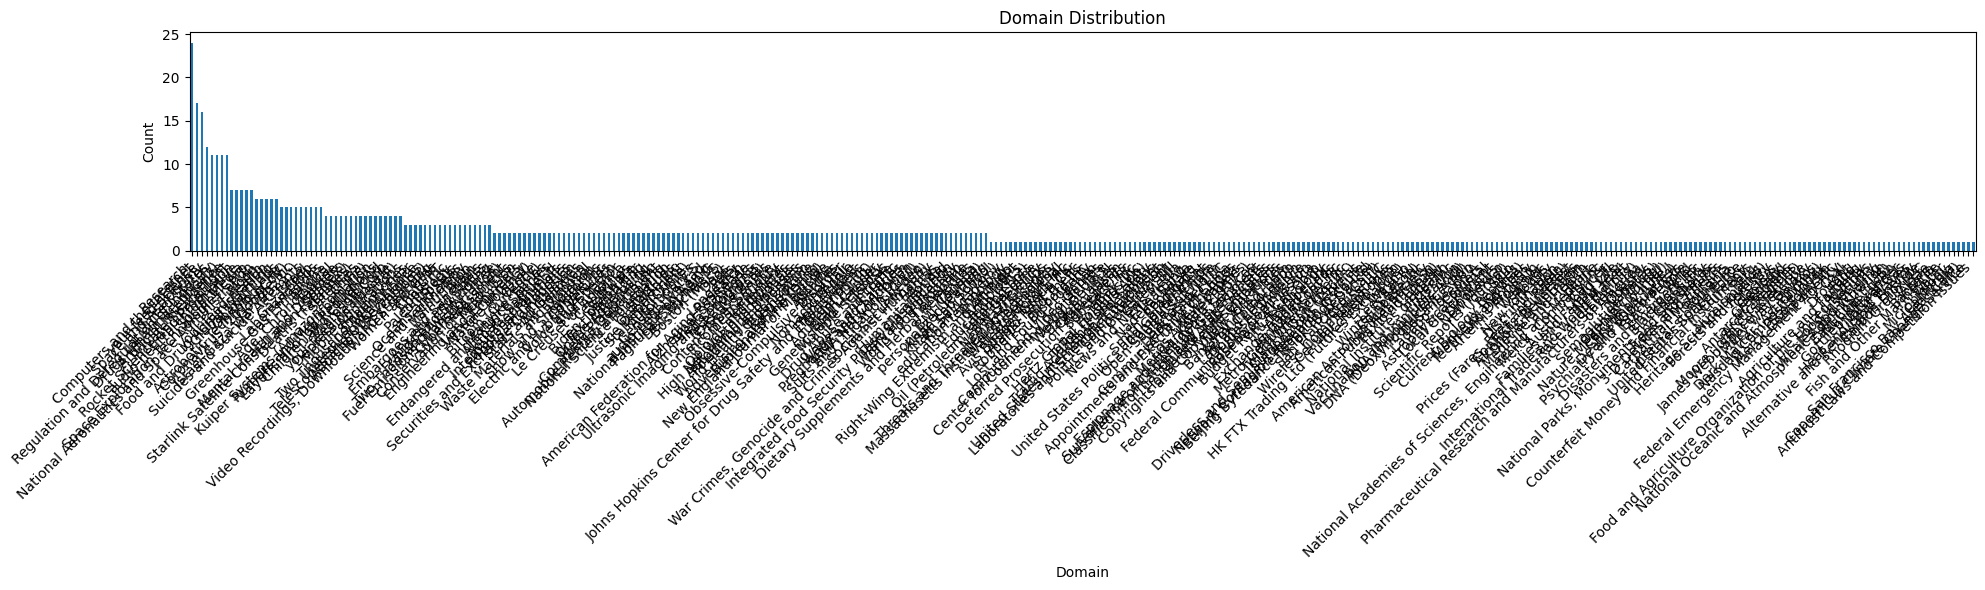

In [21]:
## Visualize Domain Distribution
import matplotlib.pyplot as plt

# Count occurrences of each domain
domain_counts = df['domains'].explode().value_counts()

# Create a larger figure
plt.figure(figsize=(20, 6))  # Adjust width and height as needed
domain_counts.plot(kind='bar', title='Domain Distribution')

# Rotate x-axis labels for better visibility
plt.xlabel('Domain')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate labels and align them to the right
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


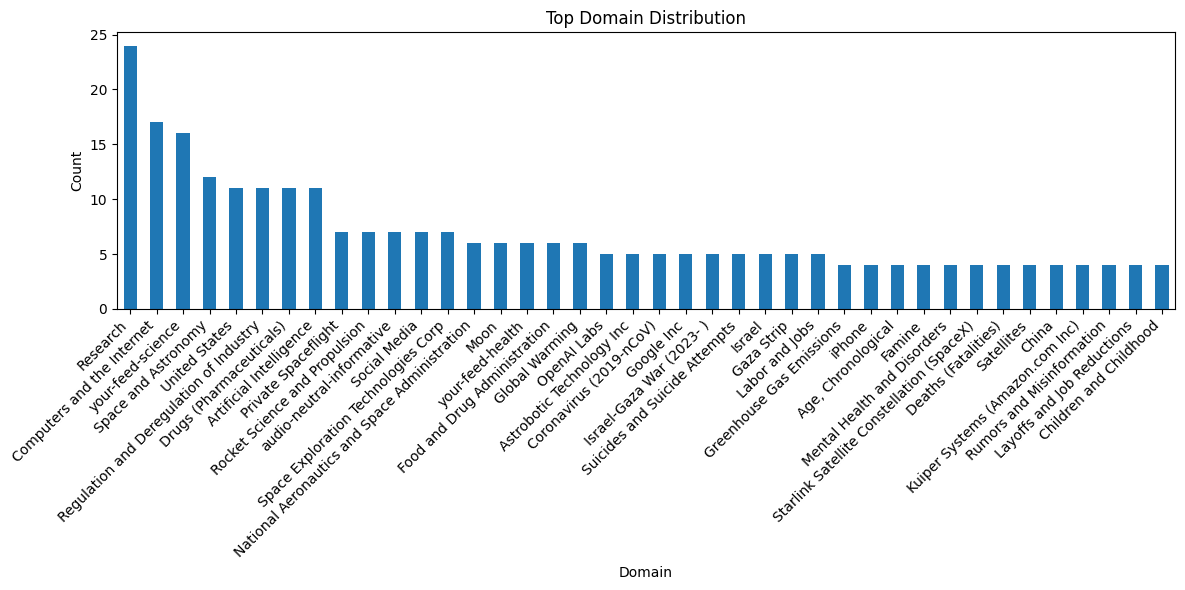

In [22]:
import matplotlib.pyplot as plt

# Count occurrences of each domain
domain_counts = df['domains'].explode().value_counts()

# Select top N domains (e.g., top 40)
top_n = 40
top_domain_counts = domain_counts.head(top_n)

# Create a larger figure
plt.figure(figsize=(12, 6))
top_domain_counts.plot(kind='bar', title='Top Domain Distribution')

# Rotate x-axis labels for better visibility
plt.xlabel('Domain')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


In [23]:
#Title Length Analysis
df['title_length'] = df['title'].apply(len)
print(df['title_length'].describe())


count    93.000000
mean     60.053763
std      14.472887
min      35.000000
25%      50.000000
50%      59.000000
75%      71.000000
max      96.000000
Name: title_length, dtype: float64


In [24]:
#Top N Articles by Length of Description
df['description_length'] = df['description'].apply(len)
top_n_descriptions = df.nlargest(10, 'description_length')
print(top_n_descriptions[['title', 'description_length']])


                                                title  description_length
92  U.S. Moves Closer to Filing Sweeping Antitrust...                 197
83  OpenAI Says New York Times Lawsuit Against It ...                 182
75  The Best and Worst of Tech: Smartphones, Self-...                 181
65  U.S. Criminally Charges EBay in Cyberstalking ...                 179
88  Help! An Employee of Budget Kept My Phone and ...                 173
71  Google Cuts Hundreds of Jobs in Engineering an...                 171
79            A.I. Giant Tied to China Under Scrutiny                 170
11  Lloyd Austin’s Hidden Diagnosis: Why Some Peop...                 168
48                Vulcan Rocket Aces Its First Launch                 168
89                Vulcan Rocket Aces Its First Launch                 168


### 8. Adding to ChromaDB


In [ ]:


def add_embeddings(collection_name, xml_filepath):
    # First Parse and Extract
    xml_parser = XMLParser(xml_filepath)
    xml_parser.parse_xml()
    result = xml_parser.extract_information()

    # Now Add it to the respective collection
    for ind, res in enumerate(result):
        domains = ""
        for domain in res['domains']:
            domains += f"{domain}, "
        collection_name.add(
            documents=f"{res['title']}" + f" Domains : {domains}",
            metadatas=[{'link':res['link']}],
            ids = [f'id{ind}']
        )

if __name__ == "__main__":
    client = chromadb.PersistentClient(path="DataBase/data")
    sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="sentence-transformers/sentence-t5-base")

    health_col = client.get_or_create_collection(name="Health", embedding_function=sentence_transformer_ef)
    science_col = client.get_or_create_collection(name="Science", embedding_function=sentence_transformer_ef)
    sports_col = client.get_or_create_collection(name="Sports", embedding_function=sentence_transformer_ef)
    tech_col = client.get_or_create_collection(name="Technology", embedding_function=sentence_transformer_ef)

    add_embeddings(health_col, 'news_xml_files/Health.xml')
    add_embeddings(science_col, 'news_xml_files/Science.xml')
    add_embeddings(sports_col, 'news_xml_files/Sports.xml')
    add_embeddings(tech_col, 'news_xml_files/Technology.xml')

    print(health_col.peek())



⚠️ It looks like you upgraded from a version below 0.6 and could benefit from vacuuming your database. Run chromadb utils vacuum --help for more information.
c:\Users\milan\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Add of existing embedding ID: id0
Add of existing embedding ID: id1
Add of existing embedding ID: id2
Add of existing embedding ID: id3
Add of existing embedding ID: id4
Add of existing embedding ID: id5
Add of existing embedding ID: id6
Add of existing embedding ID: id7
Add of existing embedding ID: id8
Add of existing embedding ID: id9
Add of existing embedding ID: id10
Add of existing embedding ID: id11
Add of e

### 9. Main Logic

In [10]:
import sys

from chromadb.utils import embedding_functions
import chromadb
import requests as req


def get_linksDB(collection_name, prompt) -> list:
    """
    Fetches related news document links from ChromaDB after performing a semantic search.
    :param collection_name: Name of the related collection
    :param prompt: User prompt to perform semantic search with chromadb
    :return:
    """
    client = chromadb.PersistentClient(path="ChromaDB_data_populate/DataBase/data")
    sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="sentence-transformers/sentence-t5-base")
    collection_name = collection_name.capitalize()
    
    try:
        # Get collections for each news type (collection corresponds to table)
        db_collection = client.get_collection(name=f"{collection_name}", embedding_function=sentence_transformer_ef)
    except InvalidCollectionException:
        print(f"Collection {collection_name} does not exist.")
        return []

    result = db_collection.query(
        query_texts=[prompt],
        n_results=3
    )
    related_links = [i['link'] for i in result['metadatas'][0]]

    return related_links



def get_news(url: str) -> list:
    if 'www.nytimes.com' in url:
        scraper = NYTimesAPI()
        news = scraper.get_response(url)  # Corrected 'link' to 'url'
        return news
    else:
        scraper = WebScraper(url)
        par = scraper.fetch_and_extract_p()
        return par


In [15]:


if __name__ == '__main__':

    user_prompt = input("Please enter keywords to find related news :   ")

    # Categorize the prompt
    model_name = 'meta/meta-llama-3-8b-instruct'
    prompt_category = categorize(user_prompt, model_name)
    print(f"Your prompt was categorized under {prompt_category}")

    # Highly unlikely case
    if not prompt_category:
        print("Exiting program because prompt category is None.")
        sys.exit()

    # Get the links
    links = get_linksDB(prompt_category, user_prompt)
    
    if not links:
        print("No related news links found.")
        sys.exit()

    # Summarize the Text
    summarizer = TextSummarizationPipeline()
    outputs = []
    for link in links:
        info = get_news(link)
        outputs.append(summarizer.generate_summary(info))

    # Print the outputs
    print("Here are AI generated summaries of some related news articles:")
    for link, out in zip(links, outputs):
        if 'generated_text' in out[0]:
            print(f"Link: {link}")
            print(out[0]['generated_text'])
        else:
            print(f"Error: No generated text for {link}")
        print("-----------------------")

Your prompt was categorized under 
Exiting program because prompt category is None.


SystemExit: 

In [17]:
if __name__ == '__main__':
    user_prompt = input("Please enter keywords to find related news: ")
    print(f"User prompt: {user_prompt}")  # Debugging line

    # Categorize the prompt
    model_name = 'meta/meta-llama-3-8b-instruct'
    prompt_category = categorize(user_prompt, model_name)

    # Highly unlikely case
    if prompt_category is None:
        print("Exiting program because prompt category is None.")
        print("Please check if the input prompt is valid and the model is functioning correctly.")
        sys.exit()

    # Get the links
    links = get_linksDB(prompt_category, user_prompt)
    
    if not links:
        print("No related news links found.")
        sys.exit()

    # Summarize the Text
    summarizer = TextSummarizationPipeline()
    outputs = []
    for link in links:
        info = get_news(link)
        outputs.append(summarizer.generate_summary(info))

    # Print the outputs
    print("Here are AI generated summaries of some related news articles:")
    for link, out in zip(links, outputs):
        if 'generated_text' in out[0]:
            print(f"Link: {link}")
            print(out[0]['generated_text'])
        else:
            print(f"Error: No generated text for {link}")
        print("-----------------------")


User prompt: Rocket lauches in recent days


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'abstract': 'After a flawless launch to orbit, the privately built robotic Peregrine lander is unlikely to reach the lunar surface because of a failure in its propulsion system.', 'web_url': 'https://www.nytimes.com/2024/01/08/science/nasa-moon-lander-malfunction-peregrine.html', 'snippet': 'After a flawless launch to orbit, the privately built robotic Peregrine lander is unlikely to reach the lunar surface because of a failure in its propulsion system.', 'lead_paragraph': 'The first NASA-financed commercial mission to send a robotic spacecraft to the surface of the moon will most likely not be able to make it there.', 'print_section': 'A', 'print_page': '15', 'source': 'The New York Times', 'multimedia': [{'rank': 0, 'subtype': 'xlarge', 'caption': None, 'credit': None, 'type': 'image', 'url': 'images/2024/01/08/multimedia/08moon-lander-qmtg/08moon-lander-qmtg-articleLarge.jpg', 'height': 399, 'width': 600, 'legacy': {'xlarge': 'images/2024/01/08/multimedia/08moon-lander-qmtg/08moon